<a href="https://colab.research.google.com/github/Slautin/2025_GP_BO_Manifolds/blob/main/GP_BO_Manifolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Manifold BO-GP. Dummy example

11/02/2025

Boris Slautin

In [40]:
!pip install -U botorch gpytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

In [2]:
#auxilary

import io
import imageio.v2 as imageio
from PIL import Image

from IPython.display import Image as IPyImage, display

def figs_to_gif(figs, gif_path, duration=0.5, loop=0):
    """
    Convert a list of matplotlib figure objects into an animated GIF.

    Parameters
    ----------
    figs : list of matplotlib.figure.Figure
        List of Matplotlib figure objects.
    gif_path : str
        Path to save the GIF (e.g. 'animation.gif').
    duration : float, optional
        Time per frame in seconds. Default is 0.5.
    loop : int, optional
        Number of loops (0 = infinite). Default is 0.
    """
    images = []

    for fig in figs:
        buf = io.BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        img = Image.open(buf).convert('RGB')
        images.append(img)
        buf.close()

    # Save as GIF using Pillow
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=duration * 1000,  # Pillow expects milliseconds
        loop=loop
    )
    print(f"GIF saved to {gif_path}")

In [16]:
# --- Convert to Cartesian coordinates for plotting ---
def barycentric_to_cartesian(x, y, z):
    A = np.array([1, 0])
    B = np.array([0, 0])
    C = np.array([0.5, np.sqrt(3)/2])
    return np.outer(x, A) + np.outer(y, B) + np.outer(z, C)

def generate_ternary_space(step=0.1):
    """
    Generate the compositional space for a ternary system A_xB_yC_{1-x-y}.

    Parameters
    ----------
    step : float
        Grid resolution (e.g., 0.1 -> 11x11 grid of valid compositions).
    plot : bool
        If True, plots the ternary composition points.

    Returns
    -------
    compositions : np.ndarray
        Array of shape (N, 3), where each row is (x_A, x_B, x_C).
    coords : np.ndarray
        2D Cartesian coordinates for plotting.
    """

    # --- Generate valid composition triplets (x+y+z=1) ---
    compositions = []
    for x in np.arange(0, 1 + step, step):
        for y in np.arange(0, 1 - x + step, step):
            if x + y <= 1:
                compositions.append((x, y, 1 - x - y))
    compositions = np.array(compositions)

    coords = barycentric_to_cartesian(compositions[:, 0], compositions[:, 1], compositions[:, 2])

    return compositions, coords

#functioality distribution in the comb. spce i
def f_xyz(x, y, z):
    """
    Smooth but structured function with multiple gentle maxima/minima.
    Modify 'centers', 'amps', and 'sigmas' for different topographies.
    """
    val = 0.6*x*x + 0.4*y*y + 0.5*z*z + 0.1*x*y - 0.05*x*z + 0.08*y*z

    # Add Gaussian bumps/dips
    centers = np.array([
        [0.65, 0.25, 0.10],  # near A-rich
        [0.15, 0.70, 0.15],  # near B-rich
        [0.20, 0.15, 0.65],  # near C-rich
    ])
    amps = np.array([+0.35, +0.20, -0.30])   # amplitude (positive = bump, negative = dip)
    sigmas = np.array([0.08, 0.10, 0.09])    # width of each Gaussian

    p = np.stack([x, y, z], axis=-1)
    for c, a, s in zip(centers, amps, sigmas):
        d2 = np.sum((p - c)**2, axis=-1)
        val += a * np.exp(-d2 / (2 * s * s))
    return val

#generation of the random cross-sections in the comb. space
def generate_random_sections(gp_model, M=5, n_points=100, boundary=False, plot=True):

    def sample_boundary_point():
        """Random point on simplex boundary (x=0, y=0, or x+y=1)."""
        r = np.random.rand()
        edge = np.random.choice([0, 1, 2])
        if edge == 0:   # x = 0 → B–C edge
            x, y = 0, r
        elif edge == 1: # y = 0 → A–C edge
            x, y = r, 0
        else:           # x + y = 1 → A–B edge
            x, y = r, 1 - r
        return np.array([x, y, 1 - x - y])

    def sample_simplex_point():
      """Uniform random point inside the ternary simplex (x >= 0, y >= 0, x + y <= 1)."""
      u, v = np.random.rand(2)
      if u + v > 1:  # reflect into simplex
          u, v = 1 - u, 1 - v
      x, y = u, v
      return np.array([x, y, 1 - x - y])

    def section_between(p, q, n):
        t = np.linspace(0, 1, n)
        return (1 - t)[:, None] * p + t[:, None] * q

    def evaluate_line(line):
        X = torch.tensor(line, dtype=torch.double)
        posterior = gp_model.posterior(X)
        mean = posterior.mean.detach().numpy().ravel()
        std = posterior.variance.sqrt().detach().numpy().ravel()
        return mean, std

    sections = []
    if boundary:
      sample_point = sample_boundary_point
    else:
      sample_point = sample_simplex_point
    for _ in range(M):
        p, q = sample_point(), sample_point()
        while np.allclose(p, q):  # avoid identical endpoints
            q = sample_point()
        line = section_between(p, q, n_points)
        mean, std = evaluate_line(line)
        sections.append({"p": p, "q": q, "line": line, "mean": mean, "std": std})

    return sections


def vis_space(coords, labels = None):
  plt.figure(figsize=(7, 7))
  if labels is not None:
    plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='jet', s=60, edgecolor='k')
  else:
    plt.scatter(coords[:, 0], coords[:, 1], c='dodgerblue', s=60, edgecolor='k')
  plt.title("Combinatorial Space for A$_x$B$_y$C$_{1-x-y}$", fontsize=14,y=1.07)
  plt.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
  plt.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
  plt.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')
  plt.axis('off')
  plt.show()


def vis_mean_std(coords, mean, std, points=None):
  fig, ax = plt.subplots(1, 2, figsize=(14,5))

  im0 = ax[0].scatter(coords[:, 0], coords[:, 1], c=mean, s=30, edgecolor='k', alpha=.7)
  plt.colorbar(im0)
  ax[0].set_title('Mean', y=1.08, fontsize=14)
  im1 = ax[1].scatter(coords[:, 0], coords[:, 1], c=std, s=30, edgecolor='k', alpha=.7)
  ax[1].set_title('STD', y=1.08, fontsize=14)
  plt.colorbar(im1)

  for _ in ax:
      if points is not None:
        plt.scatter(points[:, 0], points[:, 1], marker='x', c='red', s=30, alpha=.7)

      _.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
      _.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
      _.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')
      _.axis('off')


  plt.show()

  return fig

def vis_sections(grid_coords, sections, labels=None, best_one=None):

    fig = plt.figure(figsize=(6,5))
    plt.scatter(coords[:, 0], coords[:, 1], c=mean, s=35, alpha=.7)


    for line in sections:
      comp = line["line"]
      coord_line = barycentric_to_cartesian(comp[:,0], comp[:,1], comp[:,2])

      plt.plot(coord_line[:,0], coord_line[:,1],'--', alpha=0.8, c='k', lw=1)

    if best_one is not None:
      best_line = sections[best_one]["line"]
      best_coords = barycentric_to_cartesian(best_line[:,0],
                                             best_line[:,1],
                                             best_line[:,2])

      plt.plot(best_coords[:,0], best_coords[:,1],'--', c='r', lw=2)

    plt.axis('off')
    plt.title("Combinatorial Space for A$_x$B$_y$C$_{1-x-y}$", fontsize=14,y=1.07)
    plt.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
    plt.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
    plt.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')

    plt.show()
    return fig

def vis_both(coords, mean, std, sections, points=None, labels=None, best_one=None, iter =None):

  fig, ax = plt.subplots(1, 3, figsize=(20,5))

  im0 = ax[1].scatter(coords[:, 0], coords[:, 1], c=mean, s=30, edgecolor='k', alpha=.7)
  plt.colorbar(im0)
  ax[1].set_title('Mean', y=1.08, fontsize=14)
  im1 = ax[2].scatter(coords[:, 0], coords[:, 1], c=std, s=30, edgecolor='k', alpha=.7)
  ax[2].set_title('STD', y=1.08, fontsize=14)
  plt.colorbar(im1)

  ax[0].scatter(coords[:, 0], coords[:, 1], c=mean, s=35, alpha=.7)

  for line in sections:
    comp = line["line"]
    coord_line = barycentric_to_cartesian(comp[:,0], comp[:,1], comp[:,2])

    ax[0].plot(coord_line[:,0], coord_line[:,1],'--', alpha=0.1, c='k', lw=1)

  if best_one is not None:
    best_line = sections[best_one]["line"]
    best_coords = barycentric_to_cartesian(best_line[:,0],
                                             best_line[:,1],
                                             best_line[:,2])

  ax[0].plot(best_coords[:,0], best_coords[:,1],'--', c='r', lw=2)
  ax[0].set_title('Selected trajectory', y=1.08, fontsize=14)

  for _ in ax:
    if points is not None:
      ax[1].scatter(points[:, 0], points[:, 1], marker='x', c='red', s=30, alpha=.7)

      _.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
      _.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
      _.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')
      _.axis('off')

  if iter is not None:
    fig.suptitle(f"--- ITER {iter} ---", y=1.13)
  plt.show()

  return fig


In [17]:
#acqusition

import numpy as np
import torch
from scipy.stats import norm

def expected_improvement(mean, std, f_best, xi=0):
    """Standard Expected Improvement (EI)."""
    z = (mean - f_best - xi) / (std + 1e-12)
    ei = (mean - f_best - xi) * norm.cdf(z) + std * norm.pdf(z)
    ei[std < 1e-12] = 0.0
    return ei

def gp_line_info_gain(gp_model, X_np, noise_var=None):
    """Information gain from kernel covariance along a line."""
    X = torch.as_tensor(X_np, dtype=torch.double)
    post = gp_model.posterior(X)
    cov = post.mvn.covariance_matrix.detach().numpy()
    if noise_var is None:
        try:
          # safely extract scalar even if 0-D array
          noise_val = gp_model.likelihood.noise.detach().cpu().numpy()
          noise_var = float(np.squeeze(noise_val))
        except Exception:
            noise_var = 1e-6
    M = np.eye(cov.shape[0]) + cov / noise_var
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * logdet

def acquisition_for_sections(gp_model, sections, f_best, alpha=0.5):
    """
    Compute acquisition value for each section from generate_random_sections().

    Parameters
    ----------
    gp_model : BoTorch GP
        Trained GP model.
    sections : list
        Output of generate_random_sections().
    f_best : float
        Best observed function value so far.
    alpha : float
        Weight between exploitation (EI) and exploration (Info gain).
    """
    results = []
    scores = np.array([])
    for s in sections:
        line = s["line"]

        # --- GP posterior along the line ---
        X = torch.as_tensor(line, dtype=torch.double)
        post = gp_model.posterior(X)
        mean = post.mean.detach().numpy().ravel()
        std = post.variance.sqrt().detach().numpy().ravel()

        # --- Exploitation: Expected Improvement ---
        ei = expected_improvement(mean, std, f_best)
        ei_score = np.mean(ei)

        # --- Exploration: kernel-aware Info gain ---
        info_gain = gp_line_info_gain(gp_model, line)
        info_score = info_gain / len(line)

        # --- Combine ---
        score = alpha * ei_score + (1 - alpha) * info_score
        scores = np.append(scores, score)
        results.append({
            "p": s["p"],
            "q": s["q"],
            "score": score,
            "ei_mean": ei_score,
            "info_per_cost": info_score,
            "mean": mean,
            "std": std,
            "line": line
        })
    return scores, results


# acquisition_qEI
import numpy as np
import torch
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler

def gp_line_info_gain(gp_model, X_np, noise_var=None):
    """Information gain from kernel covariance along a line."""
    X = torch.as_tensor(X_np, dtype=torch.double)
    post = gp_model.posterior(X)
    cov = post.mvn.covariance_matrix.detach().numpy()
    if noise_var is None:
        try:
            noise_var = float(gp_model.likelihood.noise.detach().numpy())
        except Exception:
            noise_var = 1e-6
    M = np.eye(cov.shape[0]) + cov / noise_var
    sign, logdet = np.linalg.slogdet(M)
    return 0.5 * logdet

def acquisition_for_sections_qEI(gp_model, sections, f_best, alpha=0.5, num_samples=512):
    """
    Compute acquisition value for each section using batch q-Expected Improvement
    combined with information gain.

    Parameters
    ----------
    gp_model : BoTorch GP
        Trained GP model.
    sections : list
        Output of generate_random_sections().
    f_best : float
        Best observed function value so far.
    alpha : float
        Weight between exploitation (qEI) and exploration (Info gain).
    num_samples : int
        Number of Monte Carlo samples for qEI estimation.
    """
    sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_samples]))
    results, scores = [], np.array([])

    for s in sections:
        line = s["line"]
        X = torch.as_tensor(line, dtype=torch.double)

        # --- Exploitation: batch q-EI for the entire line ---
        qEI = qLogExpectedImprovement(model=gp_model, best_f=float(f_best), sampler=sampler)
        with torch.no_grad():
            qei_val = qEI(X.unsqueeze(0)).item()

        # --- Exploration: kernel-aware Info gain ---
        info_gain = gp_line_info_gain(gp_model, line)
        info_score = info_gain / len(line)

        # --- Combined acquisition ---
        score = alpha * qei_val + (1 - alpha) * info_score
        scores = np.append(scores, score)

        results.append({
            "p": s["p"],
            "q": s["q"],
            "score": score,
            "qei": qei_val,
            "info_per_cost": info_score,
            "line": line
        })

    return scores, results


In [ ]:
# def vis_space(coords, labels = None):
#   fig = plt.figure(figsize=(7, 7))
#   if labels is not None:
#     plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap='jet', s=60, edgecolor='k')
#   else:
#     plt.scatter(coords[:, 0], coords[:, 1], c='navy', s=30, edgecolor='none')
#   plt.title("Combinatorial Space for A$_x$B$_y$C$_{1-x-y}$", fontsize=14,y=1.07)
#   #plt.text(0, -0.07, "B", ha='center', fontsize=13, fontweight='bold')
#   #plt.text(1, -0.07, "A", ha='center', fontsize=13, fontweight='bold')
#   #plt.text(0.5, np.sqrt(3)/2 + 0.07, "C", ha='center', fontsize=13, fontweight='bold')
#   plt.axis('off')
#   plt.show()
#   return fig

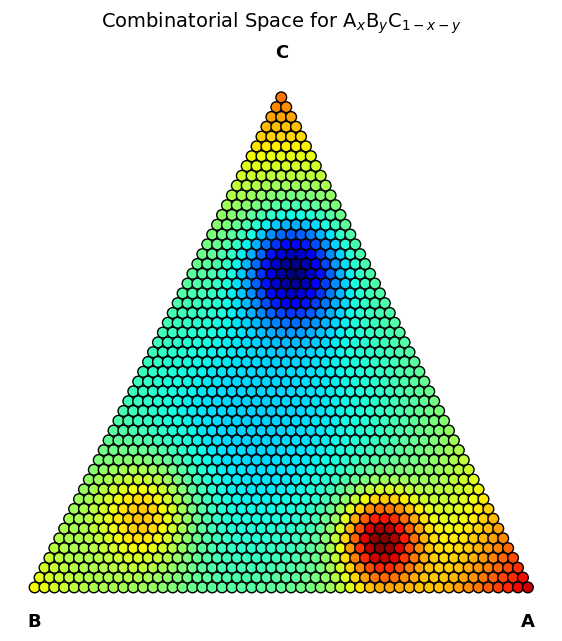

In [9]:
#ground truth
compositions, coords = generate_ternary_space(step=0.02)
z = f_xyz(*compositions.T)
fig = vis_space(coords, labels=z)

#fig.savefig('grig.png', transparent=True, bbox_inches='tight', dpi=300)

In [ ]:

n_iter = 30

M = 100 #number of random cross-section at each iteration (substitution of the grid search)
n_points = 10 #number of points per crossection
alpha = 1 # 0 - pure exproration, 1 - pure exploitation


#1 seed points
idx = np.random.choice(len(compositions), size=5, replace=False)  # 5 training points
X_train_np = compositions[idx]
coords_train = coords[idx]
y_train_np = f_xyz(X_train_np[:,0], X_train_np[:,1], X_train_np[:,2])

X_train = torch.tensor(X_train_np, dtype=torch.double)
y_train = torch.tensor(y_train_np, dtype=torch.double).unsqueeze(-1)


#2 seed model
gp = SingleTaskGP(X_train, y_train)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

X_test = torch.tensor(compositions, dtype=torch.double)
posterior = gp.posterior(X_test)
mean = posterior.mean.detach().numpy().ravel()
std = posterior.variance.sqrt().detach().numpy().ravel()
kernel_length = gp.covar_module.lengthscale.detach().cpu().numpy()

fig_mean_std = vis_mean_std(coords, mean, std, points=coords_train)

figs_m_std = [fig_mean_std, ]
kl = [kernel_length, ]
figs_cs = []
figs_both = []

#3 iterate
for iter in range(n_iter):
  print(f"------ iter {iter} ------")

  #3.1 generating cross-sections
  sections = generate_random_sections(gp, M=M, n_points=n_points, boundary=True)

  #3.2 calculate acquisition function: alpha*mean(EI) + (1-alpha)*info_gain
  scores, res = acquisition_for_sections_qEI(gp, sections, y_train_np.max(), alpha=alpha)#acquisition_for_sections(gp, sections, y_train_np.max(), alpha=0)
  next_idx = np.argmax(scores)
  fig_sect = vis_sections(coords, sections, labels=mean, best_one=next_idx)
  figs_cs.append(fig_sect)

  #3.3 update input
  next_compositions = sections[next_idx]['line']
  next_y = f_xyz(next_compositions[:,0],
                 next_compositions[:,1],
                 next_compositions[:,2])

  X_train_np = np.vstack([X_train_np, next_compositions])
  y_train_np = np.append(y_train_np, next_y)

  X_train = torch.tensor(X_train_np, dtype=torch.double)
  y_train = torch.tensor(y_train_np, dtype=torch.double).unsqueeze(-1)

  coords_train = barycentric_to_cartesian(X_train_np[:,0],
                                          X_train_np[:,1],
                                          X_train_np[:,2])

  #3.4 iterate gp
  gp = SingleTaskGP(X_train, y_train)
  mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
  fit_gpytorch_mll(mll);

  X_test = torch.tensor(compositions, dtype=torch.double)
  posterior = gp.posterior(X_test)
  mean = posterior.mean.detach().numpy().ravel()
  std = posterior.variance.sqrt().detach().numpy().ravel()
  kernel_length = gp.covar_module.lengthscale.detach().cpu().numpy()

  kl.append(kernel_length)



  fig_mean_std = vis_mean_std(coords, mean, std, points=coords_train)
  figs_m_std.append(fig_mean_std)


  fig_both = vis_both(coords, mean, std, sections,
                      points=coords_train,
                      labels=mean,
                      best_one=next_idx,
                      iter=iter)
  figs_both.append(fig_both)

kl = np.array(kl)










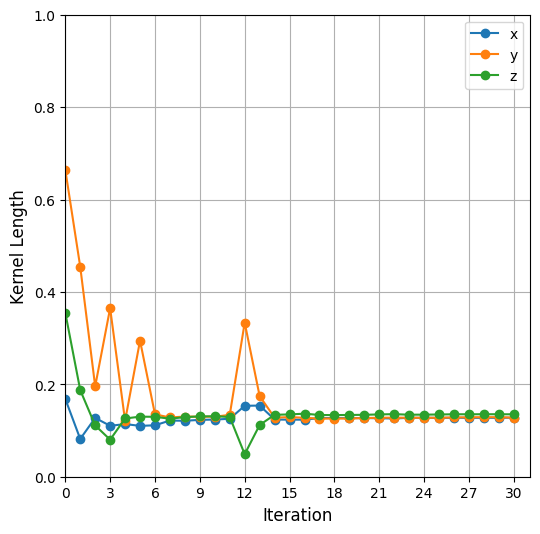

In [33]:
lbs = ['x','y', 'z']

fig = plt.figure(figsize=(6,6))

for i, kkll in enumerate(kl.squeeze().T):
  plt.plot(kkll, 'o-', label=lbs[i])

plt.grid()
plt.legend()
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Kernel Length', fontsize=12)
plt.xlim(0,len(kkll)+.1)
plt.ylim(0,1)
plt.xticks(np.arange(11)*3);

In [34]:
#gifs
figs_to_gif(figs_m_std, 'mean_std.gif')
figs_to_gif(figs_cs, 'cs.gif')
figs_to_gif(figs_both, 'both.gif')

GIF saved to mean_std.gif
GIF saved to cs.gif
GIF saved to both.gif


In [ ]:
display(IPyImage(filename='both.gif'))

In [ ]:
display(IPyImage(filename='mean_std.gif'))

In [ ]:
display(IPyImage(filename='cs.gif'))